# Clasificación

Hemos mencionado que las tareas de aprendizaje supervisado más comunes son la regresión (predicción de valores) y la clasificación (predicción de clases). En el tema anterior, trabajamos sobre una tarea de regresión, la predicción de valores de viviendas, utilizando varios algoritmos: regresión lineal, árboles de decisión y bosques aleatorios. Ahora nos centraremos en los sistemas de clasificación.

## Configuraciones previas

Primero, vamos a importar algunos módulos comunes, asegurarnos de que MatplotLib visualiza las figuras en línea y preparar una función para guardar las figuras. También comprobaremos que Python 3.5 o posterior está instalado, así como Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

Utilizaremos el conjunto de datos **MNIST**, que es un conjunto de 70.000 pequeñas
imágenes de **dígitos escritos a mano** por estudiantes de secundaria y empleados de la Oficina del Censo de EEUU.

- Cada imagen está **etiquetada** con el dígito que representa.

Scikit-Learn proporciona muchas funciones de ayuda para descargar conjuntos de datos populares. MNIST es uno de ellos. El siguiente código obtiene la base de datos MNIST:

> **Atención:** desde Scikit-Learn 0.24, `fetch_openml()` devuelve un Pandas `DataFrame` por defecto. Para evitar esto y trabajar con un array NumPy, usamos `as_frame=False`.

In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Los conjuntos de datos cargados por Scikit-Learn suelen tener una estructura de diccionario similar que incluye:

- Una clave `DESCR` que describe el conjunto de datos
- Una clave `data` que contiene una matriz con una fila por instancia y una columna por
característica
- Una clave `target` que contiene una matriz con las etiquetas.

Veamos estas matrices:

In [36]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [37]:
y.shape

(70000,)

Hay 70.000 imágenes, y cada imagen tiene 784 características. Esto se debe a que cada imagen es de 28×28 píxeles, y cada característica representa simplemente la intensidad de un píxel, de 0 (blanco) a 255 (negro).

In [41]:
28 * 28

784

Veamos un dígito del conjunto de datos. Basta con coger el vector de características de una instancia, darle forma de matriz de 28×28 y mostrarlo con la función Matplotlib `imshow()`:

Saving figure some_digit_plot


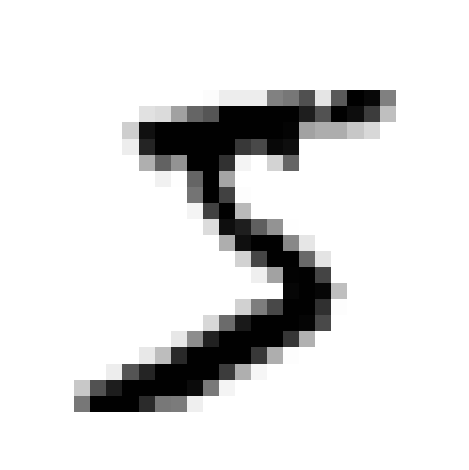

In [54]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

Parece un 5, y de hecho eso es lo que nos dice la etiqueta:

In [55]:
y[0]

'5'

Observa que la etiqueta es una cadena. Es preferible trabajar con números, así que convirtamos `y` a entero:

In [57]:
y = y.astype(np.uint8)

In [58]:
y[0]

np.uint8(5)

La siguiente figura muestra algunas imágenes más del MNIST:

In [59]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [60]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


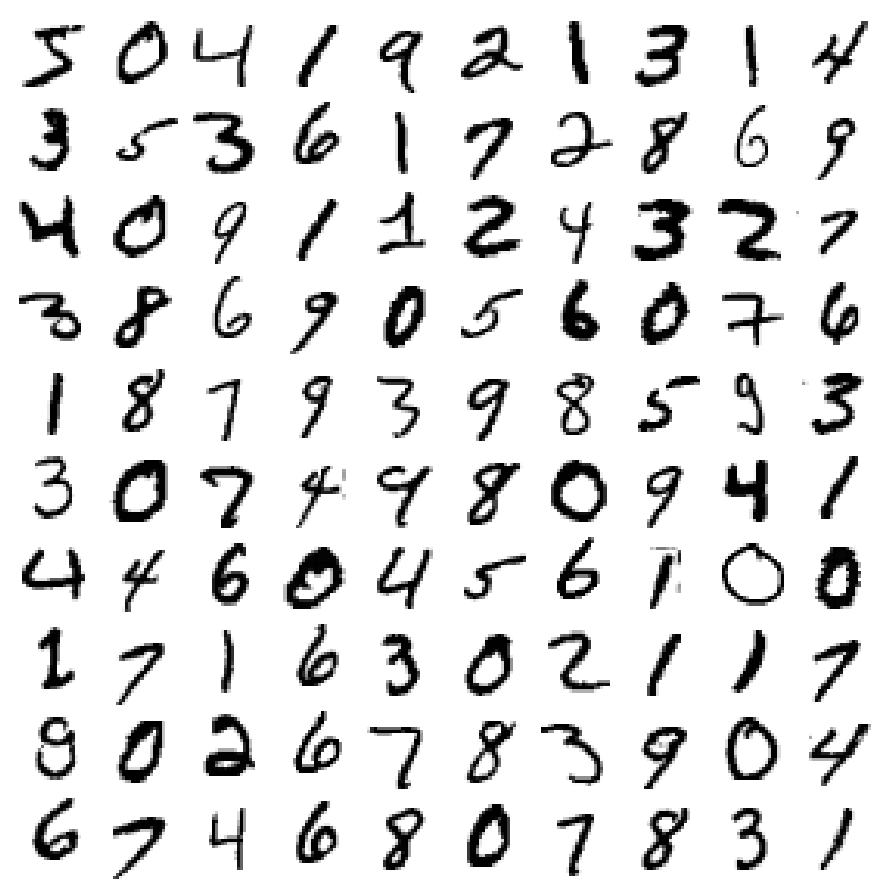

In [63]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

**Siempre se debe crear un conjunto de test y dejarlo a un lado antes de inspeccionar los datos**.

El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60.000 imágenes) y un conjunto de test (las últimas 10.000 imágenes):

In [64]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**El conjunto de entrenamiento ya está barajado para nosotros**,

- lo que es bueno, ya que garantiza que todos los conjuntos de validación cruzada serán similares (no queremos que a un pliegue le falten algunos dígitos).

- Además, algunos algoritmos de aprendizaje son sensibles al orden de las muestras de entrenamiento y obtienen malos resultados si reciben muchas muestras similares seguidas.

- Barajar el conjunto de datos garantiza que esto no ocurra.

## Entrenamiento de un clasificador binario

**Simplifiquemos el problema** e intentemos **identificar sólo un dígito**, por ejemplo, el número 5.

- Este "detector de 5" es un ejemplo de clasificador binario,

  - capaz de distinguir entre sólo dos clases, **5** y **no-5**.

- Vamos a crear los vectores objetivo para esta tarea de clasificación:

In [66]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Ahora vamos a elegir un clasificador y entrenarlo**.

- Un buen lugar para empezar es con un clasificador **Stochastic Gradient Descent (SGD)**, usando la clase `SGDClassifier` de Scikit-Learn.

- Este clasificador
es capaz de manejar conjuntos de datos muy grandes de manera eficiente.

- Esto se debe en parte a que SGD trata las muestras de entrenamiento de forma independiente, de una en una
(lo que también hace que SGD sea adecuado para *aprendizaje on-line*), como veremos más adelante.

- Crearemos un `SGDClassifier` y lo entrenaremos con todo el conjunto de entrenamiento.

> **Nota**: algunos hiperparámetros tendrán un valor diferente en futuras versiones de Scikit-Learn, como `max_iter` y `tol`. Para estar preparados para el futuro, establecemos explícitamente estos hiperparámetros a sus futuros valores por defecto.

> **Nota**: El `SGDClassifier` se basa en la aleatoriedad durante el entrenamiento (de ahí el nombre de "estocástico"). Si desea obtener resultados reproducibles
Debemos establecer el parámetro `random_state`.

In [67]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


Ahora puedes utilizarlo para detectar imágenes con número 5:

In [71]:
sgd_clf.predict([some_digit])

array([ True])

El clasificador adivina que esta imagen representa un 5 (Verdadero).

- Parece que en este caso ha acertado.
- Ahora, evaluemos el rendimiento de este modelo.

## Medidas de rendimiento

### Medición de la exactitud (accuracy) mediante validación cruzada

---
Ocasionalmente, necesitaremos más control sobre el proceso de validación cruzada que el que Scikit-Learn proporciona.

- En estos casos, podemos implementar la validación cruzada nosotros mismos; en realidad es bastante sencillo.
- El siguiente código hace aproximadamente lo mismo que la función `cross_val_score()` de Scikit-Learn, y muestra el mismo resultado:

In [72]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


La clase `StratifiedKFold` realiza un muestreo estratificado para producir particiones que contengan una proporción representativa de cada clase.

- En cada iteración, el código código crea un clon del clasificador, entrena a ese clon en las particiones de entrenamiento, y hace predicciones en la partición de test.

- A continuación, cuenta el número de predicciones correctas y la proporción de predicciones correctas.

---

**Utilicemos la función `cross_val_score()`** para evaluar nuestro modelo `SGDClassifier` utilizando la validación cruzada K-fold, con tres particiones.

- Recordemos que K-fold cross validation significa dividir el conjunto de entrenamiento en K particiones (en este caso, tres), luego hacer predicciones y evaluarlas en cada partición con un modelo entrenado en las particiones restantes:

In [73]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

¡Vaya! ¿Más del 95% de exactitud (porcentaje de predicciones correctas) en todos los conjuntos de validación cruzada? Parece increíble, ¿verdad?

- Bueno, antes de que te emociones demasiado, veamos un clasificador muy tonto que simplemente clasifica cada imagen en la clase "no-5":

In [74]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

¿Puedes adivinar la exactitud de este modelo? Averigüémoslo:

In [75]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Así es, ¡tiene más del 90% de exactitud!

- Esto se debe simplemente a que sólo alrededor del 10% de las imágenes son 5s, por lo que si siempre adivinas que una imagen no es un 5, acertarás alrededor del 90% de las veces.

- Esto demuestra por qué la exactitud no suele ser la medida de rendimiento más adecuada para los clasificadores, especialmente cuando se trata de **conjuntos de datos asimétricos** (es decir, cuando algunas clases son mucho más frecuentes que otras).

### Matriz de confusión

Una forma mucho mejor de evaluar el rendimiento de un clasificador es observar la **matriz de confusión**.

- La idea general es contar el número de veces que las muestras de la clase A se clasifican como clase B.
  - Por ejemplo, para saber el número de veces que el clasificador confunde imágenes de 5s con 3s, se miraría en la 5ª fila y 3ª columna de la matriz de confusión. de confusión.

Para calcular la matriz de confusión, primero hay que tener un conjunto de predicciones, para poder compararlas con los objetivos reales.

- Podriamos hacer predicciones en el conjunto de test, pero vamos a dejarlo intacto por ahora (recuerda que usaremos el conjunto de test sólo al final del proyecto, cuando tengamos un clasificador listo).

- En su lugar, podemos utilizar la función **`cross_val_predict()`**:

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Al igual que la función `cross_val_score(`), `cross_val_predict()` realiza una validación cruzada de K particiones,

- pero en lugar de devolver las puntuaciones de evaluación, devuelve las predicciones realizadas en cada partición de prueba.
- Esto significa que se obtiene una predicción limpia para cada muestra del conjunto de entrenamiento ("limpia" significa que el modelo hace predicciones sobre datos que no ha visto durante el entrenamiento).

Ahora estamos listos para obtener la matriz de confusión utilizando la función **`confusion_matrix()`**.

- Sólo tenemos que pasarle las clases objetivo (`y_train_5`) y las clases predichas (`y_train_pred`):

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Cada fila de una matriz de confusión representa una **clase real**, mientras que cada columna representa una **predicción**.

- La primera fila de esta matriz considera las imágenes no-5 (la **clase negativa**): 53.892 de ellas se clasificaron correctamente como no-5 (se denominan **verdaderos negativos**), mientras que las 687 restantes se clasificaron erróneamente como 5 (**falsos positivos**).

- En la segunda fila se consideran las imágenes de 5s (la **clase positiva**): 1.325 se clasificaron erróneamente como no 5s (**falsos negativos**), mientras que las 4.096 restantes se clasificaron correctamente como 5s (**verdaderos positivos**).

Un **clasificador perfecto** sólo tendría verdaderos positivos y verdaderos negativos,

- por lo que su matriz de confusión sólo tendría valores distintos de cero en su diagonal principal (de arriba a la izquierda hasta abajo a la derecha):

In [ ]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precisión (Precision) y sensibilidad (Recall)

La matriz de confusión proporciona mucha información, pero a veces se prefiere una métrica más concisa.

- Una medida interesante es la exactitud de las predicciones positivas, que se denomina **precisión** del clasificador:

> $precisión=\frac{TP}{TP+FP}$

- *TP* es el número de verdaderos positivos, y *FP* es el número de falsos positivos.

- Una forma trivial de tener una precisión perfecta es hacer una única predicción positiva y asegurarse de que es correcta (precisión = 1/1 = 100%.

  - Esto no sería muy útil, ya que el clasificador ignoraría todas las muestras positivas excepto una.

Por tanto, la precisión se suele utilizar junto con otra métrica llamada **exhaustividad**, también llamada **sensibilidad** o **tasa de verdaderos positivos (TPR)**:

- es la proporción de muestras positivas detectadas correctamente por el clasificador.

> $recall=\frac{TP}{TP+FN}$.

- FN es, por supuesto, el número de falsos negativos.

Scikit-Learn proporciona varias funciones para calcular las métricas del clasificador, incluidas la precisión y la sensibilidad:

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

A menudo es conveniente combinar la precisión y la recuperación en una única métrica llamada **$F_1$ score**,

- en particular si necesitas una forma sencilla de comparar dos clasificadores. La puntuación $F_1$ es la **media armónica de la precisión y la sensibilidad**.

- Mientras que la media normal trata todos los valores por igual, la media armónica da mucha más importancia a los valores bajos.

- Como resultado, el clasificador sólo obtendrá una puntuación $F_1$ alta si tanto la recuperación como la precisión son altas.

> $F_1 = 2 \times \frac{precisión \times recall}{precisión + recall}$.

Para calcular la puntuación $F_1$, basta con llamar a la función **`f1_score()`**:

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [ ]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

La puntuación $F_1$ favorece a los clasificadores que tienen una precisión y una sensibilidad similares.

- Esto no es siempre lo que se desea:

  - en algunos contextos le importa sobre todo la precisión, y en otros contextos lo que realmente importa es la sensibilidad.

Por desgracia, no se pueden tener ambas cosas:

- aumentar la precisión reduce la sensibilidad, y viceversa.
- Es lo que se conoce como **compromiso precisión/sensibilidad** (Precision/Recall trade-off).

### Compromiso Precision/Recall

Para entender este equilibrio, veamos cómo el `SGDClassifier` toma sus decisiones de clasificación.

- Para cada muestra, calcula una puntuación basada en una función de decisión, y si esa puntuación es mayor que un umbral, asigna la muestra a la clase positiva, o bien la asigna a la clase negativa.

- La figura muestra unos dígitos situados desde la puntuación más baja, a la izquierda, hasta la más alta, a la derecha:

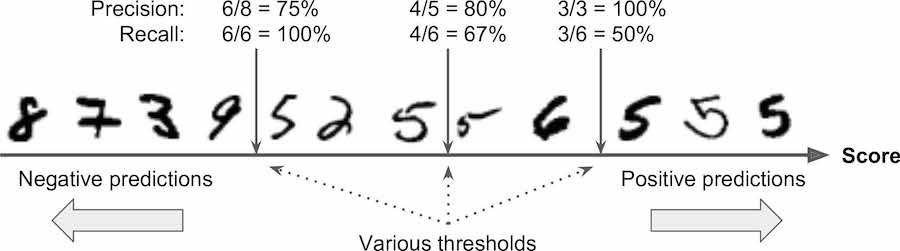

Supongamos que el **umbral de decisión** se sitúa en la flecha central (entre los dos 5): encontrará 4 verdaderos positivos (5 reales) a la derecha de ese umbral, y un falso positivo (en realidad un 6).

- Por tanto, con ese umbral, la precisión es del 80% (4 de 5).
- Pero de los 6 cincos reales, el clasificador sólo detecta 4, por lo que la sensibilidad es del 67% (4 de 6).
- Ahora bien, si se eleva el umbral (moviéndolo hacia la flecha de la derecha), el falso positivo (el 6) se convierte en un verdadero negativo,

  - aumentando así la precisión (hasta el 100% en este caso),
  - pero un verdadero positivo se convierte en un falso negativo, disminuyendo la sensibilidad hasta el 50%.

- Por el contrario, si se reduce el umbral, aumenta la sensibilidad y disminuye la precisión.

Scikit-Learn no permite establecer el umbral directamente, pero sí da acceso a las puntuaciones de decisión que utiliza para hacer predicciones.

- En lugar de llamar al método `predict()` del clasificador, podemos llamar al método **`decision_function()`**, que devuelve una puntuación para cada muestra,
- y luego hacer predicciones basadas en esas puntuaciones utilizando cualquier umbral que desee:

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

array([ True])

En este caso, el `SGDClassifier` utiliza un umbral igual a 0,

- por lo que el código anterior devuelve el mismo resultado que el método `predict()` (es decir, `True`).

Aumentemos el umbral:

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Esto confirma que el aumento del umbral disminuye la sensibilidad.

- La imagen representa en realidad un 5,
- y el clasificador lo detecta cuando el umbral es 0,
- pero no lo detecta cuando el umbral aumenta a 8.000.

¿Cómo decidimos qué umbral utilizar?

- Para ello, primero tendrá que obtener las puntuaciones de todas las muestras del conjunto de entrenamiento mediante la función `cross_val_predict()` de nuevo,
- pero esta vez especificando que desea que devuelva puntuaciones de decisión en lugar de
predicciones:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Ahora, con estas puntuaciones, podemos calcular la precisión y la sensibilidad para todos los umbrales posibles utilizando la función **`precision_recall_curve()`**:

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Por último, podemos representar gráficamente la precisión y la sensibilidad como funciones del valor umbral utilizando Matplotlib:

Saving figure precision_recall_vs_threshold_plot


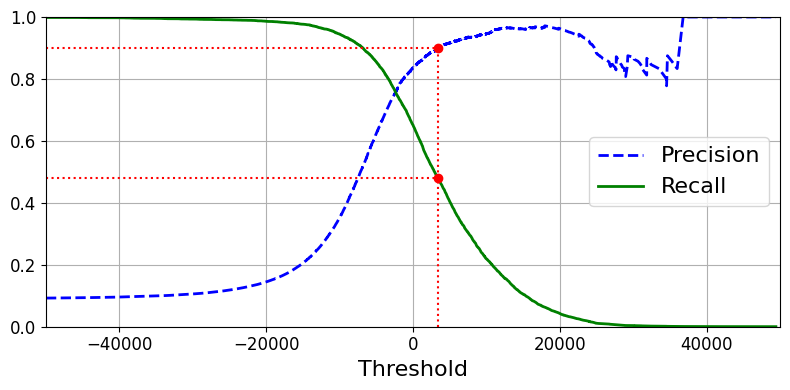

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [ ]:
(y_train_pred == (y_scores > 0)).all()

True

Otra forma de seleccionar un buen equilibrio entre precisión y recuperación es **trazar la precisión directamente frente a la recuperación** (se resalta el mismo umbral que antes).

Saving figure precision_vs_recall_plot


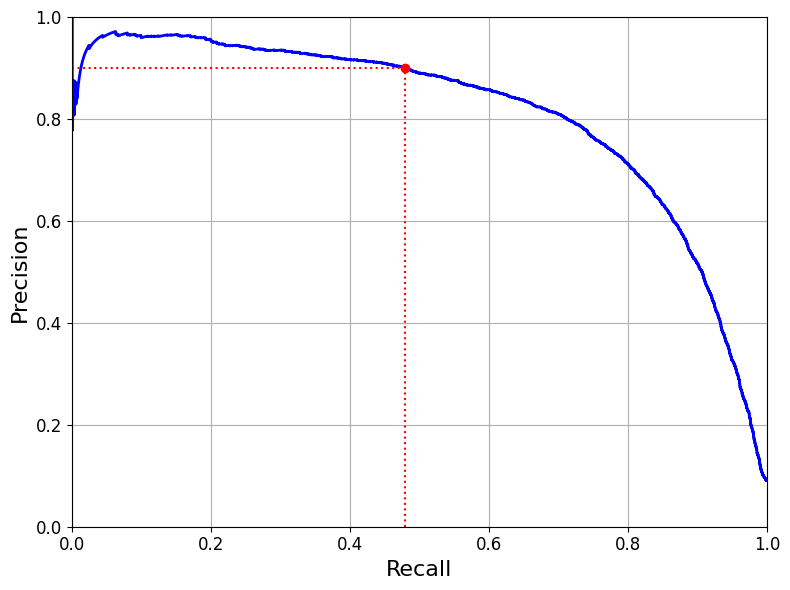

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

Podemos ver que la precisión empieza a caer bruscamente en torno al 80% de recall.

- Es probable que desee seleccionar un punto de equilibrio entre precisión y sensibilidad justo antes de esa caída, por ejemplo, en torno al 60% de sensibilidad.
- Pero, por supuesto, la mejor elección depende del proyecto.
- Supongamos que decide alcanzar una precisión del 90%.
- Busquemos en el primer gráfico y veremos que hay que utilizar un umbral de 8.000 aproximadamente.
  - Para ser más preciso, hay que buscar el umbral más bajo que dé al menos un 90% de precisión (`np.argmax()` nos dará el primer índice del valor máximo, que en este caso significa el primer valor `True`):

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier’s `predict()` method, you can just run this code:

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Comprobemos la precisión y el recuerdo de estas predicciones:

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Genial, ¡tienes un clasificador con un 90% de precisión!

- Como puede ver, es bastante fácil crear un clasificador clasificador con prácticamente cualquier precisión que deseemos: basta con establecer un umbral lo suficientemente alto, y ya está.
- No tan rápido. **Un clasificador de alta precisión no es muy útil si su sensibilidad es demasiado baja**.

### Curva ROC

La curva ROC **(receiver operating characteristic)** es otra herramienta común utilizada con clasificadores binarios.

- Es muy similar a la curva de precisión/recuperación, pero en lugar de trazar precisión frente a la recuperación, la curva ROC traza la **tasa de verdaderos positivos** (TPR, otro nombre para la sensibilidad) **contra la tasa de falsos positivos** (FPR).
- La FPR es la proporción de muestras negativas que
se clasifican incorrectamente como positivos.
  - Es igual a **uno menos la tasa de verdaderos negativos** (TNR),
que es la proporción de muestras negativas clasificadas correctamente como negativas.
- La TNR también se denomina **especificidad**.
  - Por lo tanto, la curva ROC representa la sensibilidad frente a
1 - especificidad.

Para trazar la curva ROC, primero hay que calcular el TPR y el FPR para varios valores de umbral, utilizando la función **`roc_curve()`**:

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib.

Saving figure roc_curve_plot


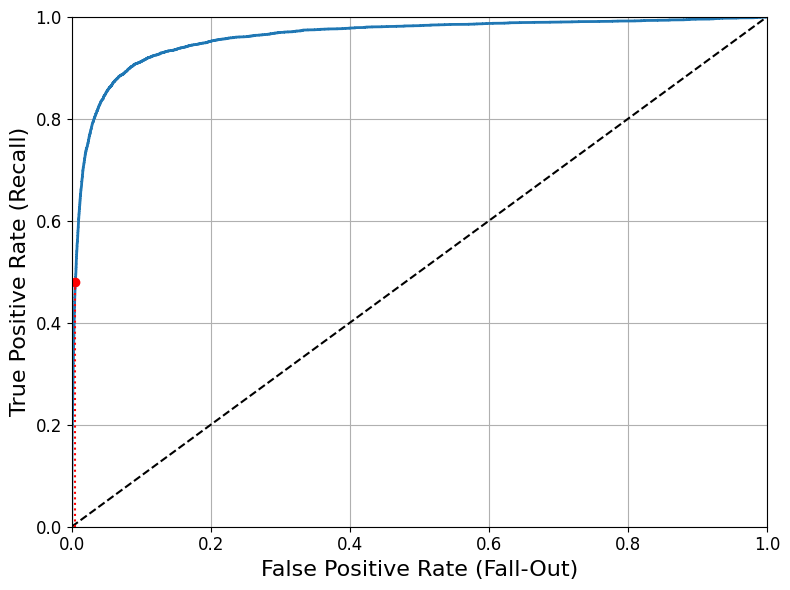

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("roc_curve_plot")
plt.show()

Una vez más, existe un compromiso:

- cuanto mayor sea la recuperación (TPR), más falsos positivos
(FPR) produce el clasificador.

- La línea de puntos representa la curva ROC de un clasificador puramente
aleatorio;
  - Un buen clasificador se mantiene lo más alejado posible de esa línea (hacia la esquina superior izquierda).
la esquina superior izquierda).

Una forma de comparar clasificadores es medir el **área bajo la curva** (AUC).

- Un clasificador perfecto tendrá un AUC ROC igual a 1, mientras que un clasificador puramente aleatorio tendrá un AUC ROC igual a 0,5.
- Scikit-Learn proporciona una función para calcular el AUC ROC:

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Entrenemos un `RandomForestClassifier` y comparemos su curva ROC y su puntuación ROC AUC con el `SGDClassifier`.

- En primer lugar, es necesario obtener las puntuaciones de cada muestra del conjunto de entrenamiento.

- Pero debido a su funcionamiento, la clase `RandomForestClassifier` no tiene un método `decision_function()`.

- En su lugar tiene un método **`predict_proba()`**.

- Los clasificadores de Scikit-Learn suelen tener uno u otro.

- El método `predict_proba()` devuelve una matriz que contiene una fila por instancia y una columna por clase, cada una de las cuales contiene la probabilidad de que la instancia dada pertenezca a la clase dada (por ejemplo, 70% de probabilidad de que la imagen represente un 5).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Pero para trazar una curva ROC se necesitan puntuaciones, no probabilidades.

- Una solución sencilla es utilizar la probabilidad de la clase positiva como puntuación:

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Ahora ya podemos trazar la curva ROC.

- Es útil trazar también la primera curva ROC para ver la comparación:

Saving figure roc_curve_comparison_plot


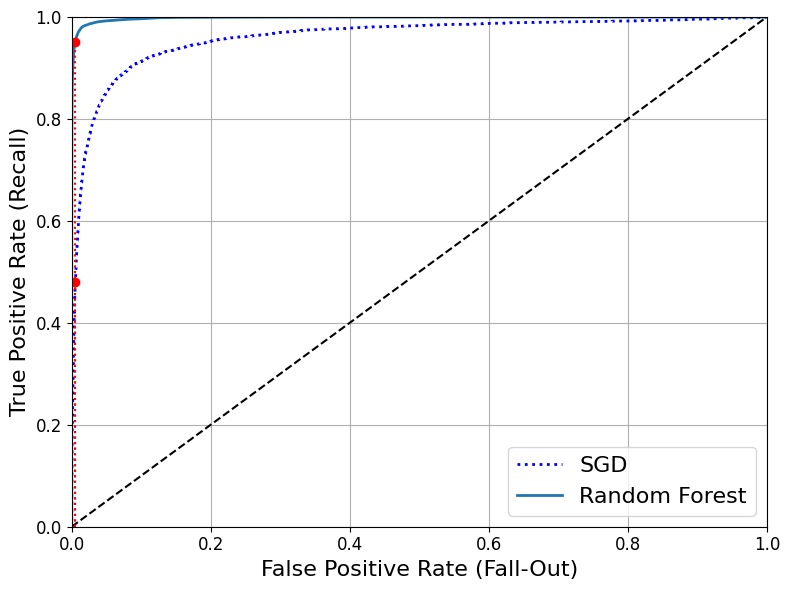

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

La curva ROC del `RandomForestClassifier` se ve mucho mejor que la del `SGDClassifier`:

- se acerca mucho más a la esquina superior izquierda. Como resultado, su puntuación AUC ROC también es significativamente mejor:

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Probemos a medir las puntuaciones de precisión y sensibilidad:

- 99,0% de precisión y 86,6% de sensibilidad. No está nada mal.

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Ahora ya sabemos cómo entrenar clasificadores binarios,
1. elegir la métrica adecuada para su tarea,
2. evaluar los clasificadores mediante validación cruzada,
3. seleccionar el compromiso precisión/sensibilidad que se ajuste a sus necesidades,
4. y comparar varios modelos utilizando curvas ROC y puntuaciones ROC AUC.

Ahora intentemos detectar algo más que los 5s.

## Clasificación multiclase

Mientras que los clasificadores binarios distinguen entre dos clases, los **clasificadores multiclase** (también llamados clasificadores multinomiales) pueden distinguir entre **más de dos** clases.

- Algunos algoritmos (como los clasificadores Random Forest o los clasificadores Naive Bayes) son capaces de manejar múltiples clases directamente.
- Otros (como los clasificadores Support Vector Machine o los clasificadores lineales) son clasificadores estrictamente binarios.
  - Sin embargo, hay varias estrategias que puede utilizar para realizar una clasificación multiclase utilizando varios clasificadores binarios.

Por ejemplo, una forma de crear un sistema que pueda clasificar las imágenes de dígitos en 10 clases (de 0 a 9) es entrenar 10 clasificadores binarios, uno para cada dígito (un detector 0, un detector 1, un detector 2, etc.).

- Luego, cuando se quiere clasificar una imagen, se obtiene la puntuación de la decisión de cada clasificador para esa imagen y se selecciona la clase cuyo clasificador da la puntuación más alta.
- Esto se denomina estrategia **one-versus-all** (**OvA**) (también llamada **one-versus-the-rest**).

Otra estrategia consiste en entrenar un clasificador binario para cada par de dígitos: uno para distinguir 0s y 1s, otro para distinguir 0s y 2s, otro para 1s y 2s, y así sucesivamente.

- Esto se denomina estrategia **one-versus-one** (OvO).
- Si hay N clases, es necesario entrenar N × (N - 1) / 2 clasificadores.
  - Para el problema MNIST, esto significa entrenar 45 clasificadores binarios.

Scikit-Learn detecta cuando se intenta utilizar un algoritmo de clasificación binario para una tarea de clasificación multiclase, y automáticamente ejecuta OvA (excepto para los clasificadores SVM para los que utiliza OvO).

Probemos esto con el `SVC`:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Bajo el capó,
1. Scikit-Learn entrenó 10 clasificadores binarios,
2. obtuvo sus puntuaciones de decisión para la imagen, y
3. seleccionó la clase con la puntuación más alta.

Para ver que este es el caso, podemos llamar al método `decision_function()`.

- En lugar de devolver sólo una puntuación por muestra, ahora devuelve 10 puntuaciones, una por clase.

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

La puntuación más alta es la correspondiente a la clase 5:

In [ ]:
np.argmax(some_digit_scores)

5

Cuando se entrena un clasificador, almacena la lista de clases objetivo en su atributo `classes_`, ordenadas por valor.

- En este caso, el índice de cada clase en la matriz `classes_` coincide convenientemente con la propia clase (por ejemplo, la clase en el índice 5 resulta ser la clase 5), pero en general no tendremos tanta suerte.

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

Si quieres **forzar** a ScikitLearn a usar  one-versus-one o one-versus-all, puedes usar las clases `OneVsOneClassifier` o `OneVsRestClassifier`.

- Simplemente crea una muestra y pasa un clasificador binario a su constructor.

Por ejemplo, este código crea un clasificador multiclase utilizando la estrategia OvO, basado en un `SGDClassifier`:

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovo_clf.estimators_)

45

Entrenar un `RandomForestClassifier` es tan fácil como:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

Esta vez Scikit-Learn no tuvo que ejecutar OvA u OvO porque los clasificadores Random Forest pueden clasificar directamente las muestras en varias clases.

 - Podemos llamar a `predict_proba()` para obtener la lista de probabilidades que el clasificador asignó a cada muestra para cada clase:

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Se puede ver que el clasificador tiene bastante confianza en su predicción:

- el 0,9 en el índice 5 de la matriz significa que el modelo estima en un 90% la probabilidad de que la imagen represente un 5. También piensa que la imagen podría ser en cambio un 2, un 3 o un 9, respectivamente, con un 1% y un 8% de probabilidad.
- También cree que la imagen podría ser un 2, un 3 o un 9, respectivamente, con un 1%, un 8% y un 1% de probabilidad.

Por supuesto, ahora queremos evaluar estos clasificadores. Como de costumbre, se utiliza la validación cruzada. Por ejemplo, evaluemos la exactitud del `SGDClassifier` usando la función `cross_val_score()`:

> **Warning**: las siguientes dos celdas pueden tardar cerca de 30 minutos en ejecutarse, o más dependiendo de tu hardware.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Se obtiene más del 84% en todas las particiones de validación.

- Si utilizara un clasificador aleatorio, obtendría un 10% de de exactitud, por lo que no es tan mala puntuación, pero aún se puede mejorar mucho.

Por ejemplo, simplemente **escalando las entradas** (como se ha comentado anteriormente) aumenta la exactitud por encima del 89%:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Análisis de errores

Por supuesto, si se tratara de un proyecto real, se seguirían los siguientes pasos:

1. explorar las opciones de preparación de datos,
2. probar varios modelos,
3. seleccionar los mejores, y
4. ajuste (fine-tunning) de sus hiperparámetros utilizando GridSearchCV, y automatización en la medida de lo posible.

Aquí, vamos a suponer que usted ha encontrado un modelo prometedor y quiere encontrar maneras de mejorarlo.

- Una forma de hacerlo es **analizar los tipos de errores** que comete.

En primer lugar, puedes mirar la matriz de confusión.
- Tenemos que calcular predicciones utilizando la función
función `cross_val_predict()`,
- luego llamar a la función `confusion_matrix()`, igual que como hicimos antes:

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Son muchos números.

- A menudo es más conveniente mirar una representación gráfica de la matriz de confusión, utilizando la función `matshow()` de Matplotlib:

In [ ]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


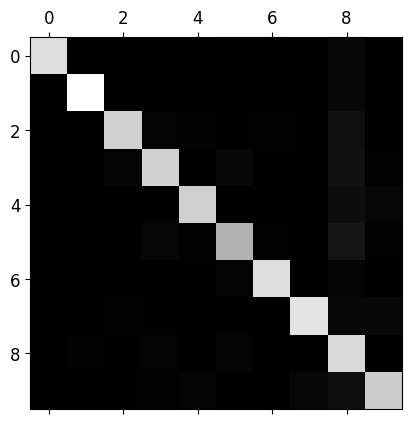

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Esta matriz de confusión se ve bastante bien, ya que la mayoría de las imágenes están en la diagonal principal, lo que significa que fueron clasificadas correctamente.
- Los 5 se ven ligeramente más oscuros que otros dígitos, lo que podría significar que hay menos imágenes de 5s en el conjunto de datos o que el clasificador no funciona tan bien con los 5s como con otros dígitos.
  - De hecho, deberíamos comprobar ambas casas.

Centremos el gráfico en los errores.
- En primer lugar, hay que dividir cada valor de la matriz de confusión por el número de imágenes de la clase correspondiente,
  - para poder comparar las tasas de error en lugar del número absoluto de errores (que haría que las clases abundantes parecieran injustamente malas):

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


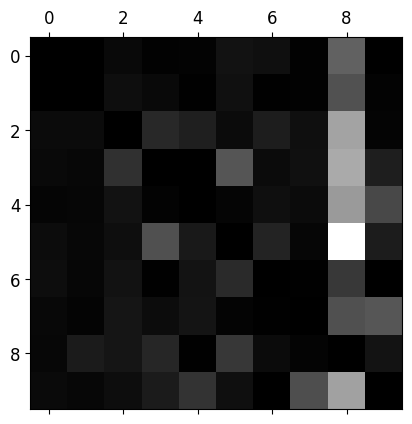

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Ahora puede ver claramente los **tipos de errores** que comete el clasificador.
- Recuerde que las filas representan las clases reales, mientras que las columnas representan las clases predichas.
- La columna para la clase 8 es bastante brillante, lo que indica que muchas imágenes se clasifican erróneamente como 8s.
  - Sin embargo, la fila de la clase 8 no es tan mala, lo que indica que los 8 reales se clasifican correctamente como 8.
- También se puede ver que los 3 y los 5 se confunden a menudo (en ambas direcciones).

**El análisis de la matriz de confusión** puede darnos ideas para mejorar nuestro clasificador.
- Mirando este gráfico, parece que debemos centrarnos en la reducción de los 8 falsos.
  - Por ejemplo, podriamos intentar reunir más datos de entrenamiento para dígitos que parecen 8 (pero no lo son) para que el clasificador aprenda a distinguirlos de los 8 reales.
- También se podrían diseñar nuevas características que ayudaran al clasificador, por ejemplo, escribir un algoritmo para contar el número de bucles cerrados (por ejemplo, 8 tiene dos, 6 tiene uno, 5 no tiene ninguno).
- O se podría preprocesar las imágenes (por ejemplo, utilizando Scikit-Image, Pillow, u OpenCV) para que algunos patrones destaquen más, como los bucles cerrados.

**Analizar los errores individuales** también puede ser una buena forma de comprender lo que está haciendo tu clasificador y por qué está fallando, pero es más difícil y lleva más tiempo.

- Por ejemplo, vamos a trazar ejemplos de 3s y 5s (la función `plot_digits()` sólo utiliza la función `imshow()` de Matplotlib:

Saving figure error_analysis_digits_plot


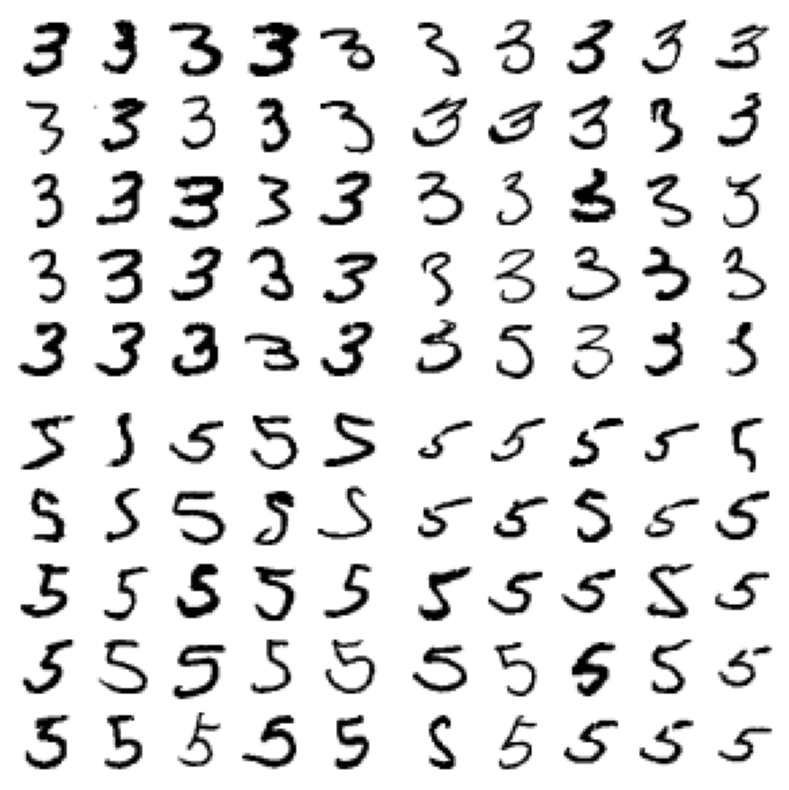

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

Los dos bloques de 5×5 de la izquierda muestran dígitos clasificados como 3s, y los dos bloques de 5×5 de la derecha muestran imágenes clasificadas como 5s.
- Algunos de los dígitos en los que el clasificador se equivoca (es decir, en los bloques inferior izquierdo y superior derecho) están tan mal escritos que incluso un humano tendría problemas para clasificarlos (por ejemplo, el 5 de la primera fila y la segunda columna parece realmente un 3 mal escrito).
- Sin embargo, la mayoría de las imágenes mal clasificadas nos parecen errores obvios, y es difícil entender por qué el clasificador cometió los errores que cometió.
  - La razón es que utilizamos un simple `SGDClassifier`, que es un modelo lineal.
  - Todo lo que hace es asignar un peso por clase a cada píxel, y cuando ve una nueva imagen simplemente suma las intensidades ponderadas de los píxeles para obtener una puntuación para cada clase.
  - Así que como 3s y 5s sólo se diferencian en unos pocos píxeles, este modelo los confundirá fácilmente.

La principal diferencia entre 3s y 5s es la posición de la pequeña línea que une la línea superior con el arco inferior.
- Si dibujas un 3 con la unión ligeramente desplazada hacia la izquierda, el clasificador podría clasificarlo como un 5, y viceversa.
- En otras palabras, este clasificador es bastante sensible al desplazamiento y la rotación de la imagen.
  - Así que una forma de reducir la confusión 3/5 sería preprocesar las imágenes para asegurarse de que están bien centradas y no demasiado rotadas.
  - Esto probablemente también ayudará a reducir otros errores.

## Clasificación multietiqueta

Hasta ahora, cada muestra se ha asignado siempre a una sola clase. En algunos casos, es posible que desee que su clasificador genere **múltiples clases para cada muestra**.
- Por ejemplo, consideremos un clasificador de reconocimiento facial: ¿qué debe hacer si reconoce a varias personas en la misma imagen?
  - Por supuesto, debe asignar una etiqueta a cada persona que reconozca.
- Supongamos que el clasificador ha sido entrenado para reconocer tres caras, Alice, Bob y Charlie;
  - entonces, cuando se le muestre una imagen de Alicia y Charlie, debería emitir [1, 0, 1] (lo que significa "Alicia sí, Bob no, Charlie sí").
- Un sistema de clasificación de este tipo que emite múltiples etiquetas binarias se denomina **sistema de clasificación multietiqueta**.

Veamos un ejemplo más sencillo:
- El siguiente código crea una matriz `y_multilabel` que contiene dos etiquetas de destino para cada imagen de dígito:
  - la primera indica si el dígito es grande (7, 8 o 9)
  - y la segunda indica si es impar o no.
- Las líneas siguientes crean una muestra de `KNeighborsClassifier` (que **soporta la clasificación multietiqueta**, no todos los clasificadores la soportan) y la entrenamos utilizando la matriz anterior.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Ahora podemos hacer una prediccióno. Observa que que produce dos etiquetas:

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

Hay muchas formas de evaluar un clasificador multietiqueta, y la selección de la métrica adecuada depende realmente del proyecto.

- Por ejemplo, un enfoque es medir $F_1$ para cada etiqueta individual (o cualquier otra métrica de clasificador binario discutida anteriormente), y luego simplemente calcular la puntuación media.
- El siguiente código calcula $F_1$ media de todas las etiquetas:

> **Warning**: la siguiente celda puede tardar mucho tiempo (posiblemente horas, dependiendo de su hardware).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

Esto supone que todas las etiquetas tienen la misma importancia, lo que puede no ser el caso.
- En concreto, si usted tiene muchas más fotos de Alice que de Bob o Charlie, es posible que desee dar más peso a la puntuación del clasificador en las imágenes de Alice.
- Una opción sencilla es es dar a cada etiqueta un peso igual a su *soporte* (es decir, el número de muestras con esa etiqueta de destino).
- Para ello, basta con establecer `average="weighted"` en el código anterior.

## Clasificación multisalida

El último tipo de tarea de clasificación que vamos a tratar aquí se denomina **clasificación multi-salida**.

- Se trata simplemente de una generalización de la clasificación multietiqueta en la que cada etiqueta puede ser multiclase (es decir, puede tener más de dos valores posibles).

Por ejemplo, construyamos un sistema que elimine el ruido de las imágenes.
- Tomará como entrada una imagen de dígitos con ruido y (con suerte) dará como salida una imagen de dígitos limpia, representada como una matriz de intensidades de píxeles, igual que las imágenes MNIST.
- Observe que la salida del clasificador es multietiqueta (una etiqueta por píxel) y que cada etiqueta puede tener varios valores (la intensidad del píxel oscila entre 0 y 255).
- Se trata, pues, de un ejemplo de sistema de clasificación multisalida.

---
**NOTA**: La línea entre clasificación y regresión es a veces difusa, como en este ejemplo.
- Podría decirse que la predicción de la intensidad de los píxeles se parece más a la regresión que a la clasificación.
- Por otra parte, los sistemas de salida múltiple no se limitan a las tareas de clasificación; incluso podría tener un sistema que produce múltiples etiquetas por muestra, incluyendo tanto las etiquetas de clase como las etiquetas de valor.

---

Empezaremos creando los conjuntos de entrenamiento y test tomando las imágenes MNIST y añadiendo ruido a sus intensidades de píxel utilizando la función `randint()` de NumPy:
- Las imágenes objetivo serán las imágenes originales.

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Veamos una imagen:

Saving figure noisy_digit_example_plot


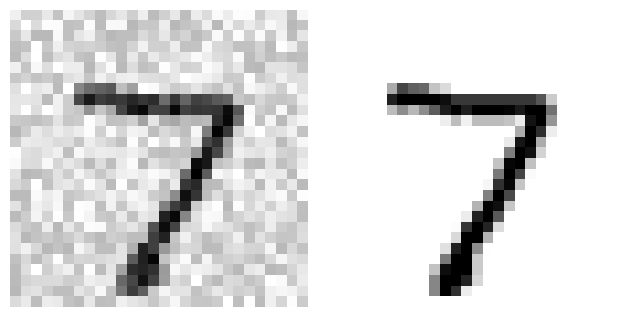

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

A la izquierda está la imagen de entrada ruidosa, y a la derecha la imagen de destino limpia.

Ahora vamos a entrenar el clasificador y hacer que limpie esta imagen:

Saving figure cleaned_digit_example_plot


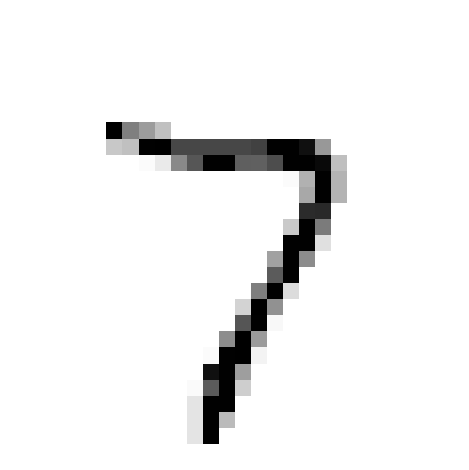

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")


## Ejercicios para entregar

### Ejercicio 1

Intenta construir un clasificador para el conjunto de datos MNIST que alcance una exactitud superior al 97% en el conjunto de test.

> **Pista**: `KNeighborsClassifier` funciona bastante bien para esta tarea; sólo tienes que encontrar buenos valores para sus hiperparámetros.

### Ejercicio 2

Escribe una función que pueda desplazar una imagen MNIST en cualquier dirección (izquierda, derecha, arriba o abajo) en un píxel.

- Puedes usar la función `shift()` del módulo scipy.ndimage.interpolation.
  - Por ejemplo, `shift(image, [2, 1], cval=0)` desplaza la imagen 2 píxeles hacia abajo y 1 píxel hacia la derecha.

A continuación, para cada imagen del conjunto de entrenamiento, crea cuatro copias desplazadas (una por dirección) y añádelas al conjunto de entrenamiento.

Por último, entrena tu mejor modelo en este conjunto de entrenamiento ampliado y mida su exactitud en el conjunto de test.

Observarás que tu modelo funciona aún mejor. Esta técnica de aumentar artificialmente el conjunto de entrenamiento se denomina **aumento de datos** o **ampliación del conjunto de entrenamiento**.

## Ejercicios no evaluables de repaso

### Ejercicio 3

Enfréntate al conjunto de datos del Titanic. El objetivo es predecir si un pasajero sobrevivió o no en función de atributos como su edad, sexo, clase, lugar de embarque, etc.

En primer lugar, inicia sesión en [Kaggle](https://www.kaggle.com/) y ve a [Titanic challenge](https://www.kaggle.com/c/titanic) para descargar train.csv y test.csv.

### Ejercicio 4
#### Este ejercicio no puntúa para la práctica.

Construye un clasificador de spam:

- Descarga ejemplos de spam
de [Apache SpamAssassin's public datasets](https://spamassassin.apache.org/old/publiccorpus/).

- Descomprime los conjuntos de datos y familiarízate con su formato.

- Divide los conjuntos de datos en un conjunto de entrenamiento y un conjunto de test.

- Crea un Pipeline de preparación de datos para convertir cada correo electrónico en un vector de características.
Tu canal de preparación debe transformar un correo electrónico en un vector
que indique la presencia o ausencia de cada palabra posible. Por ejemplo, si todos los
correos electrónicos sólo contienen cuatro palabras: "Hola", "cómo", "eres", "tú", entonces el correo electrónico "Hola tú Hola Hola tú" se convertiría en un vector [1, 0, 0, 1].
(lo que significa que ["Hola" está presente, "cómo" está ausente, "eres" está ausente, "tú" está
presente]), o [3, 0, 0, 2] si prefieres contar el número de apariciones de cada palabra.
cada palabra.

- Puedes añadir hiperparámetros a su proceso de preparación para controlar
si eliminar o no las cabeceras de los correos electrónicos, convertir cada correo electrónico a minúsculas,
eliminar la puntuación, sustituir todas las URL por "URL", sustituir todos los números por
todos los números por "NÚMERO", o incluso realizar un *stemming* (es decir, recortar el final de las palabras).
bibliotecas de Python para hacerlo).

- A continuación, prueba varios clasificadores y comprueba si puede crear un buen clasificador de spam, con un alto nivel de sensibilidad y precisión.